In [10]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchinfo import summary

import time
from PIL import Image
import numpy as np

from PythonFiles.cocodataset import myCocoDetection, coco_show
%matplotlib inline

In [66]:
import os

import torch
from torchvision.datasets import CocoDetection

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
   
class myCocoDetection(CocoDetection):
    def __init__(
        self, root, annFile, remove_invalid_data, transform):
        super(myCocoDetection, self).__init__(root, annFile)
        
        if remove_invalid_data:
            ids = []
            for img_id in self.ids:
                ann_ids = self.coco.getAnnIds(imgIds=img_id)
                anno = self.coco.loadAnns(ann_ids)
                if self.is_valid_data(anno):
                    ids.append(img_id)
            self.ids = ids
            
        self.transform = transform
        
    def is_valid_data(self, anno):
        if len(anno) == 0:
            return False
        for obj in anno:
            for o in obj['bbox'][2:]:
                if o <= 1:
                    return False
        return True
    
    def _load_image(self, idx: int):
        path = self.coco.loadImgs(idx)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")
    
    def _load_target(self, idx):
        return self.coco.loadAnns(self.coco.getAnnIds(idx))
    
    def __getitem__(self, index: int):
        idx = self.ids[index]
        image = self._load_image(idx)
        target = self._load_target(idx)
        
        bboxes, labels = [], []
        for obj in target:
            bbox = [obj['bbox'][0],
                    obj['bbox'][1],
                    obj['bbox'][0] + obj['bbox'][2],
                    obj['bbox'][1] + obj['bbox'][3]]
            bboxes.append(bbox)
            
            labels.append(obj['category_id'])
        
        if self.transform:
            image = self.transform(image)
            bboxes = self.transform(np.array(bboxes)).reshape(-1, 4)
            
            targets ={}
            labels = torch.tensor(labels).type(torch.int64)
            bboxes = bboxes.type(torch.FloatTensor)
            targets['boxes'] = bboxes
            targets['labels'] = labels
            
            return image, targets, idx        
            
        return image, bboxes, labels

In [42]:
TRAIN_BATCH_SIZE = 2
TEST_BATCH_SIZE = 2
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 50

np.random.seed(40)
torch.manual_seed(40)
torch.cuda.manual_seed(40)

# Dataset

In [43]:
train_path = '../../data/COCO/train2017'
train_ann = '../../data/COCO/annotations/instances_train2017.json'
test_path = '../../data/COCO/val2017'
test_ann = '../../data/COCO/annotations/instances_val2017.json'

trainset = myCocoDetection(root=train_path, annFile=train_ann,
                           remove_invalid_data=True,
                           transform=transforms.ToTensor())

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, collate_fn=collate_fn)


loading annotations into memory...
Done (t=16.87s)
creating index...
index created!
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


coco_show(train_loader, figsize=(2,2))

# Model

In [44]:
model = fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
summary(model, (TRAIN_BATCH_SIZE, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              --                        --
├─BackboneWithFPN: 1                                    --                        --
│    └─FeaturePyramidNetwork: 2                         --                        --
│    │    └─ModuleList: 3-1                             --                        984,064
│    │    └─ModuleList: 3-2                             --                        2,360,320
├─GeneralizedRCNNTransform: 1-1                         --                        --
├─BackboneWithFPN: 1-2                                  [2, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [2, 2048, 25, 25]         --
│    │    └─Conv2d: 3-3                                 [2, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-4                      [2, 64, 400, 400]         --
│    │    └─ReLU: 3-5                      

# CUDA

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Optimizer

In [46]:
import torch.optim as optim
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM)

# Train

In [47]:
train_loss_per_epoch_list = []
train_loss_per_iter_list = []

for e in range(EPOCHS):
    
    model.train()
    model.to(device)
    for i, (images, targets) in enumerate(train_loader):
        start = time.time()
        images = [img.to(device) for img in images]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        loss = sum(v for v in loss_dict.values())
        train_loss_per_iter_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        end = time.time()
        if i % 10000 == 0:
            print('EPOCH : [%d/%d] ---- Iter : [%d/%d] ---- Loss : %0.3f --- Time : %0.3f'
                 % (e+1, EPOCHS, i, len(train_loader), loss, (end-start)*10))
            
    train_loss_per_epoch_list.append(loss)        
    print('EPOCH : [%d/%d] ---- Iter : [%d/%d] ---- Loss : %0.3f --- Time : %0.3f \n'
            % (e+1, EPOCHS, i, len(train_loader), loss, end-start))

EPOCH : [1/50] ---- Iter : [0/58610] ---- Loss : 5.297 --- Time : 2.850
EPOCH : [1/50] ---- Iter : [10000/58610] ---- Loss : 0.662 --- Time : 3.907
EPOCH : [1/50] ---- Iter : [20000/58610] ---- Loss : 0.328 --- Time : 3.640
EPOCH : [1/50] ---- Iter : [30000/58610] ---- Loss : 0.783 --- Time : 3.610
EPOCH : [1/50] ---- Iter : [40000/58610] ---- Loss : 1.070 --- Time : 3.140
EPOCH : [1/50] ---- Iter : [50000/58610] ---- Loss : 0.579 --- Time : 3.410
EPOCH : [1/50] ---- Iter : [58609/58610] ---- Loss : 1.786 --- Time : 0.305 

EPOCH : [2/50] ---- Iter : [0/58610] ---- Loss : 0.727 --- Time : 2.220
EPOCH : [2/50] ---- Iter : [10000/58610] ---- Loss : 1.179 --- Time : 3.300


KeyboardInterrupt: 

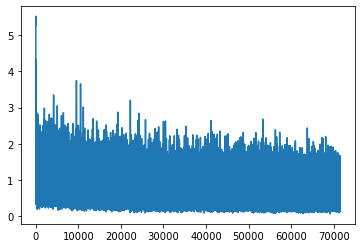

In [55]:
plt.plot(train_loss_per_iter_list)

# Test

In [51]:
    for i, (images, targets) in enumerate(train_loader):
        start = time.time()
        images = [img.to(device) for img in images]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

2476

In [64]:
model.eval()
with torch.no_grad():
    output = model(images)

In [65]:
output

[{'boxes': tensor([[ 13.9173, 169.2791, 152.0880, 264.3464],
          [290.5632, 220.2540, 365.9714, 319.8913],
          [375.6467, 219.5141, 436.9750, 317.3343],
          [167.7168, 234.5339, 185.1007, 266.8392],
          [242.9561, 199.1936, 252.6799, 212.1202],
          [422.9874, 156.7433, 464.5556, 292.0966],
          [231.2694, 173.1474, 265.0164, 213.6947],
          [549.3356, 299.4295, 584.4786, 398.7417],
          [364.9716, 237.8581, 387.6946, 318.6771],
          [ 44.5235, 212.8998,  62.0872, 240.2783],
          [360.3722, 220.6347, 399.4546, 316.3260],
          [295.7929, 212.0438, 454.9058, 318.7934],
          [571.0668, 214.1096, 640.0000, 284.6765],
          [441.7148, 339.4715, 640.0000, 419.6519],
          [309.4498, 215.7685, 437.7561, 318.5243],
          [360.7522, 215.2521, 373.7773, 229.8957],
          [361.5108, 193.1484, 461.2982, 310.9829],
          [412.0486, 219.8548, 438.3160, 291.9263],
          [331.9007, 180.4617, 366.7711, 223.0104],
   

In [67]:
testset = myCocoDetection(root=test_path, annFile=test_ann,
                          remove_invalid_data=True,
                          transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=TEST_BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [69]:
iter(test_loader).next()

((tensor([[[0.6667, 0.6784, 0.6863,  ..., 0.2706, 0.2667, 0.2745],
           [0.6745, 0.6902, 0.6941,  ..., 0.2706, 0.2824, 0.2784],
           [0.6863, 0.6941, 0.6980,  ..., 0.2745, 0.2706, 0.2784],
           ...,
           [0.7373, 0.7176, 0.7569,  ..., 0.7294, 0.7294, 0.7333],
           [0.7294, 0.7333, 0.7294,  ..., 0.7765, 0.7647, 0.7294],
           [0.7294, 0.7333, 0.7294,  ..., 0.5059, 0.4941, 0.4196]],
  
          [[0.5333, 0.5569, 0.5647,  ..., 0.2980, 0.2980, 0.2784],
           [0.5529, 0.5686, 0.5725,  ..., 0.3020, 0.3137, 0.2941],
           [0.5647, 0.5725, 0.5765,  ..., 0.3059, 0.3020, 0.2941],
           ...,
           [0.7412, 0.7176, 0.7333,  ..., 0.6157, 0.6157, 0.6118],
           [0.7176, 0.7216, 0.7176,  ..., 0.5255, 0.4706, 0.3451],
           [0.7176, 0.7216, 0.7176,  ..., 0.2353, 0.2235, 0.1608]],
  
          [[0.2863, 0.3020, 0.3098,  ..., 0.1647, 0.1529, 0.1451],
           [0.3020, 0.3137, 0.3176,  ..., 0.1569, 0.1686, 0.1569],
           [0.3098, 0.

In [70]:
images, targets, idx = iter(test_loader).next()
images = [img.to(device) for img in images]

In [71]:
idx

(139, 285)

In [ ]:
for i, (images, targets) in enumerate(test_loader):
    